In [1]:
"""author: Vetivert? 💐 
created: 28/05/2025 @ 01:47:24"""

'author: Vetivert? 💐 \ncreated: 28/05/2025 @ 01:47:24'

# LOAD DATA

In [51]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             mean_squared_error, r2_score, roc_auc_score, make_scorer) 

import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, SpatialDropout1D, Layer, BatchNormalization # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import tensorflow.keras.backend as K # type: ignore

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

In [9]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_38797/1056633048.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_38797/1056633048.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_38797/1056633048.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

# LSTM

In [ ]:
df.drop(HEART_INDEX, axis=1, inplace=True)

In [98]:
df_set = df.loc[:, 'Gende':'Oliguria'].copy().fillna(0)
df_set = df_set.apply(pd.to_numeric, errors='coerce')

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 24) y1_train shape:  (324,)
x1_test shape:  (82, 24) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [99]:
x1_train = x1_train.apply(pd.to_numeric, errors='coerce')
x1_test = x1_test.apply(pd.to_numeric, errors='coerce')
y1_train = pd.to_numeric(y1_train, errors='coerce')
y1_test = pd.to_numeric(y1_test, errors='coerce')

In [100]:
x1_train = x1_train.to_numpy()
y1_train = y1_train.to_numpy()
x1_test = x1_test.to_numpy()
y1_test = y1_test.to_numpy()
y1_train = y1_train - 1
y1_test = y1_test - 1

# x1_train = x1_train.reshape(x1_train.shape[0], 1, 24)

# x1_test = x1_test.reshape(x1_test.shape[0], 1, 24)


In [105]:
print(y1_test)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]


In [30]:
print(y1_train[0])

0


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5405 - auc_5: 0.4830 - loss: 0.6998 - precision_5: 0.2864 - recall_5: 0.0076 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 0.9685 - val_precision_5: 1.0000 - val_recall_5: 0.0244
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5704 - auc_5: 0.5143 - loss: 0.6829 - precision_5: 0.4607 - recall_5: 0.0441 - val_accuracy: 0.0366 - val_auc_5: 0.0000e+00 - val_loss: 0.9643 - val_precision_5: 1.0000 - val_recall_5: 0.0610
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - auc_5: 0.5536 - loss: 0.6820 - precision_5: 0.5767 - recall_5: 0.1492 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 1.0130 - val_precision_5: 1.0000 - val_recall_5: 0.0244
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5717 - auc_5: 0.5937 - loss: 0.6813 - precision_5: 0.6916 - recall_5: 0.1510 - val_accuracy: 0.0122 - val_auc_5: 0.0000e+00 - val_loss: 1.0001 - val_precision_5: 1

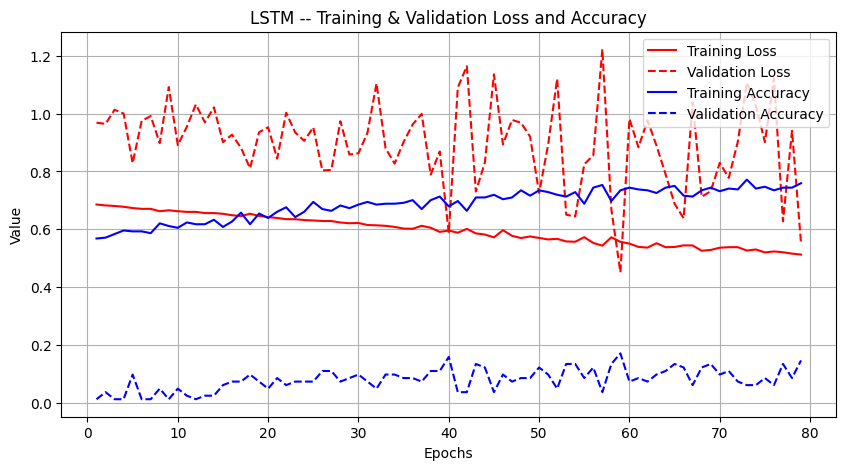

In [74]:
# Define the BiLSTM model
model = Sequential([
    Input(shape=(1, 24)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    LSTM(24),  #, kernel_initializer='he_uniform'
    Dense(1, activation='sigmoid')  # 3-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(),
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()])

# Train the model
history = model.fit(
    x1_train, y1_train,  
    epochs=100,
    batch_size=16,
    validation_data=(x1_test, y1_test),
    callbacks=[EarlyStopping(patience=20)]
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6086 - auc_6: 0.4464 - loss: 0.6770 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.9289 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5789 - auc_6: 0.6115 - loss: 0.6769 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.0122 - val_auc_6: 0.0000e+00 - val_loss: 0.9080 - val_precision_6: 1.0000 - val_recall_6: 0.0122
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5426 - auc_6: 0.5353 - loss: 0.6888 - precision_6: 0.6894 - recall_6: 0.0245 - val_accuracy: 0.0366 - val_auc_6: 0.0000e+00 - val_loss: 0.8861 - val_precision_6: 1.0000 - val_recall_6: 0.0366
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5720 - auc_6: 0.5539 - loss: 0.6813 - precision_6: 0.7523 - recall_6: 0.0288 - val_accuracy: 0.0366 - val_auc_6: 0.0000e+00 - val_loss:

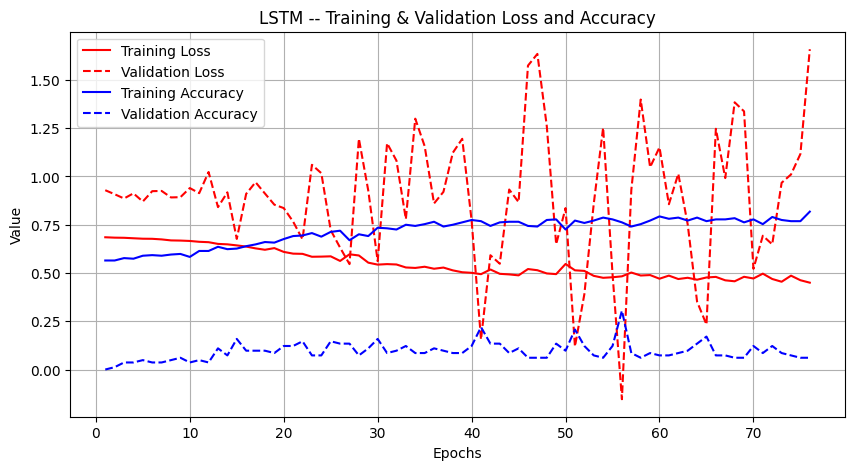

In [75]:
# Define the BiLSTM model
model_S = Sequential([
    Input(shape=(1, 24)),  # Input shape: (timesteps, features)
    Masking(mask_value=-1.0),  # Ignores padding
    LSTM(24, return_sequences=True),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    LSTM(24),  #, kernel_initializer='he_uniform'
    # Dropout(0.3),
    Dense(1, activation='sigmoid')  # 3-class classification
])

# Compile the model
model_S.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(),
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()])

# Train the model
history = model_S.fit(
    x1_train, y1_train,  
    epochs=100,
    batch_size=16,
    validation_data=(x1_test, y1_test),
    callbacks=[EarlyStopping(patience=20)]
)

# Extract values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot both accuracy and loss
plt.figure(figsize=(10, 5))

# Left Y-axis: Loss
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'r--', label="Validation Loss")

# Right Y-axis: Accuracy
plt.plot(epochs, train_acc, 'b-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b--', label="Validation Accuracy")

# Labels & Legends
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("LSTM -- Training & Validation Loss and Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

# SA-LSTM

In [113]:
def prepare_data_for_lstm(X, y):
    """Prepare data for LSTM model with attention"""
    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)  # Assuming class '2' is the positive class
    
    # Reshape input to 3D format expected by LSTM: [samples, timesteps, features]
    # For this model, we use the entire feature vector as a single timestep sequence
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, scaler

def prepare_sequence_data(X, y, n_steps=3):
    """
    Prepare data by splitting features into groups that are treated as timesteps
    This allows the attention mechanism to focus on different feature groups
    
    Args:
        X: Feature DataFrame
        y: Target values
        n_steps: Number of timesteps to divide features into
    """
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)
    
    # Calculate features per timestep
    n_features = X_scaled.shape[1]
    n_features_per_step = n_features // n_steps
    
    # Reshape into [samples, timesteps, features_per_step]
    X_reshaped = np.zeros((X_scaled.shape[0], n_steps, n_features_per_step))
    
    for i in range(n_steps):
        start_idx = i * n_features_per_step
        end_idx = start_idx + n_features_per_step if i < n_steps - 1 else n_features
        step_features = X_scaled[:, start_idx:end_idx]
        
        # Handle the last step which might have different number of features
        if step_features.shape[1] < n_features_per_step:
            # Pad with zeros if needed
            padding = np.zeros((X_scaled.shape[0], n_features_per_step - step_features.shape[1]))
            step_features = np.column_stack((step_features, padding))
            
        X_reshaped[:, i, :] = step_features
    
    return X_reshaped, y, scaler

In [ ]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    
    # LSTM layer
    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model


In [165]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_52            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_3        │ (None, 1, 24)          │            25 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_53            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_44              │ (None, 24)             │            25 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,579 (37.42 KB)

 Trainable params: 9,531 (37.23 KB)

 Non-trainable params: 48 (192.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}
Epoch 1/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5625 - auc_21: 0.5275 - loss: 0.7003 - precision_21: 0.5333 - recall_21: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6062 - auc_21: 0.6000 - loss: 0.6920 - precision_21: 0.5457 - recall_21: 0.6155 - val_accuracy: 0.6000 - val_auc_21: 0.6721 - val_loss: 0.6902 - val_precision_21: 0.5000 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 2/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_21: 0.7745 - loss: 0.6917 - precision_21: 0.6111 - recall_21: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6129 - auc_21: 0.6958 - loss: 0.6918 - precision_21: 0.5659 - recall_21: 0.6604 - val_accuracy: 0.6000 - val_auc_21: 0.7036 - val_loss: 0.6882 - val_precision_21: 0.5000 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 3/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - auc_21: 0.8355 - loss: 0.6674 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7157 - auc_21: 0.7572 - loss: 0.6833 - precision_21: 0.6333 - recall_21: 0.7980 - val_accuracy: 0.6000 - val_auc_21: 0.7441 - val_loss: 0.6858 - val_precision_21: 0.5000 - val_recall_21: 0.6538 - learning_rate: 0.0010
Epoch 4/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - auc_21: 0.6232 - loss: 0.6616 - precision_21: 0.3846 - recall_21: 0.5556

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6320 - auc_21: 0.7014 - loss: 0.6794 - precision_21: 0.5288 - recall_21: 0.6448 - val_accuracy: 0.5846 - val_auc_21: 0.7480 - val_loss: 0.6838 - val_precision_21: 0.4865 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 5/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_21: 0.7229 - loss: 0.6721 - precision_21: 0.5333 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6389 - auc_21: 0.7216 - loss: 0.6824 - precision_21: 0.5651 - recall_21: 0.7426 - val_accuracy: 0.5692 - val_auc_21: 0.7638 - val_loss: 0.6819 - val_precision_21: 0.4750 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 6/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_21: 0.7021 - loss: 0.7168 - precision_21: 0.7500 - recall_21: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6973 - auc_21: 0.7702 - loss: 0.6900 - precision_21: 0.6674 - recall_21: 0.7971 - val_accuracy: 0.5846 - val_auc_21: 0.7712 - val_loss: 0.6787 - val_precision_21: 0.4872 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 7/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_21: 0.8030 - loss: 0.6592 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7019 - auc_21: 0.7885 - loss: 0.6729 - precision_21: 0.6201 - recall_21: 0.7897 - val_accuracy: 0.6308 - val_auc_21: 0.7845 - val_loss: 0.6745 - val_precision_21: 0.5278 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 8/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_21: 0.7832 - loss: 0.6842 - precision_21: 0.6500 - recall_21: 0.8125

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6940 - auc_21: 0.7877 - loss: 0.6763 - precision_21: 0.6520 - recall_21: 0.7520 - val_accuracy: 0.6769 - val_auc_21: 0.7919 - val_loss: 0.6697 - val_precision_21: 0.5758 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 9/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - auc_21: 0.8216 - loss: 0.6733 - precision_21: 0.7059 - recall_21: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6916 - auc_21: 0.7903 - loss: 0.6678 - precision_21: 0.6250 - recall_21: 0.7680 - val_accuracy: 0.7077 - val_auc_21: 0.7894 - val_loss: 0.6636 - val_precision_21: 0.6129 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 10/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - auc_21: 0.8333 - loss: 0.6623 - precision_21: 0.7143 - recall_21: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7180 - auc_21: 0.8217 - loss: 0.6600 - precision_21: 0.6640 - recall_21: 0.7595 - val_accuracy: 0.6923 - val_auc_21: 0.8028 - val_loss: 0.6576 - val_precision_21: 0.5938 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 11/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - auc_21: 0.8385 - loss: 0.6328 - precision_21: 0.3529 - recall_21: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6920 - auc_21: 0.8227 - loss: 0.6491 - precision_21: 0.5876 - recall_21: 0.8232 - val_accuracy: 0.6923 - val_auc_21: 0.8037 - val_loss: 0.6510 - val_precision_21: 0.5938 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 12/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_21: 0.7403 - loss: 0.6469 - precision_21: 0.5556 - recall_21: 0.9091

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7422 - auc_21: 0.8146 - loss: 0.6385 - precision_21: 0.6320 - recall_21: 0.8712 - val_accuracy: 0.7231 - val_auc_21: 0.8057 - val_loss: 0.6406 - val_precision_21: 0.6333 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 13/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7812 - auc_21: 0.8333 - loss: 0.6227 - precision_21: 0.7333 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7484 - auc_21: 0.8075 - loss: 0.6326 - precision_21: 0.6999 - recall_21: 0.7720 - val_accuracy: 0.7385 - val_auc_21: 0.8102 - val_loss: 0.6292 - val_precision_21: 0.6552 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 14/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - auc_21: 0.7718 - loss: 0.6372 - precision_21: 0.6471 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7417 - auc_21: 0.8285 - loss: 0.6175 - precision_21: 0.6729 - recall_21: 0.8091 - val_accuracy: 0.7385 - val_auc_21: 0.8092 - val_loss: 0.6153 - val_precision_21: 0.6552 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 15/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - auc_21: 0.9114 - loss: 0.5573 - precision_21: 0.6429 - recall_21: 0.9000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7448 - auc_21: 0.8240 - loss: 0.5984 - precision_21: 0.6666 - recall_21: 0.7840 - val_accuracy: 0.7538 - val_auc_21: 0.8121 - val_loss: 0.5999 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 16/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6562 - auc_21: 0.7676 - loss: 0.6169 - precision_21: 0.6667 - recall_21: 0.6250

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7266 - auc_21: 0.8155 - loss: 0.5937 - precision_21: 0.7096 - recall_21: 0.6964 - val_accuracy: 0.7692 - val_auc_21: 0.8102 - val_loss: 0.5873 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 17/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - auc_21: 0.8829 - loss: 0.5297 - precision_21: 0.8000 - recall_21: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7618 - auc_21: 0.8402 - loss: 0.5621 - precision_21: 0.7196 - recall_21: 0.7403 - val_accuracy: 0.7538 - val_auc_21: 0.8126 - val_loss: 0.5780 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 18/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - auc_21: 0.8472 - loss: 0.5344 - precision_21: 0.7857 - recall_21: 0.7857

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7475 - auc_21: 0.8152 - loss: 0.5634 - precision_21: 0.6859 - recall_21: 0.7552 - val_accuracy: 0.7538 - val_auc_21: 0.8126 - val_loss: 0.5715 - val_precision_21: 0.6786 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 19/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8625 - loss: 0.5602 - precision_21: 0.6471 - recall_21: 0.9167

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7697 - auc_21: 0.8440 - loss: 0.5443 - precision_21: 0.6929 - recall_21: 0.7926 - val_accuracy: 0.7692 - val_auc_21: 0.8136 - val_loss: 0.5636 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 20/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8438 - auc_21: 0.8849 - loss: 0.4897 - precision_21: 0.8000 - recall_21: 0.8571

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7596 - auc_21: 0.8392 - loss: 0.5343 - precision_21: 0.7473 - recall_21: 0.7251 - val_accuracy: 0.7692 - val_auc_21: 0.8161 - val_loss: 0.5579 - val_precision_21: 0.7037 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 21/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8438 - auc_21: 0.8725 - loss: 0.4701 - precision_21: 0.9167 - recall_21: 0.7333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7904 - auc_21: 0.8571 - loss: 0.5070 - precision_21: 0.7630 - recall_21: 0.7474 - val_accuracy: 0.7846 - val_auc_21: 0.8161 - val_loss: 0.5522 - val_precision_21: 0.7500 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 22/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6250 - auc_21: 0.7471 - loss: 0.5600 - precision_21: 0.6154 - recall_21: 0.5333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7417 - auc_21: 0.8223 - loss: 0.5283 - precision_21: 0.7123 - recall_21: 0.6936 - val_accuracy: 0.7692 - val_auc_21: 0.8166 - val_loss: 0.5510 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 23/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - auc_21: 0.8452 - loss: 0.4985 - precision_21: 0.7143 - recall_21: 0.7143

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7510 - auc_21: 0.8264 - loss: 0.5250 - precision_21: 0.7286 - recall_21: 0.7106 - val_accuracy: 0.7692 - val_auc_21: 0.8180 - val_loss: 0.5508 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 24/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7865 - auc_21: 0.8822 - loss: 0.4696 - precision_21: 0.7933 - recall_21: 0.7424 - val_accuracy: 0.7692 - val_auc_21: 0.8161 - val_loss: 0.5530 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 0.0010
Epoch 25/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7728 - auc_21: 0.8440 - loss: 0.5006 - precision_21: 0.7692 - recall_21: 0.7458 - val_accuracy: 0.7846 - val_auc_21: 0.8111 - val_loss: 0.5564 - val_precision_21: 0.7308 - val_recall_21: 0.7308 - learning_rate: 0.0010
Epoch 26/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7489 - auc_21: 0.8329 - loss: 0.5052 - precision_21: 0.6806 - recall_21: 0.7727 - val_accuracy: 0.7

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8010 - auc_21: 0.8679 - loss: 0.4650 - precision_21: 0.7761 - recall_21: 0.7701 - val_accuracy: 0.7846 - val_auc_21: 0.8057 - val_loss: 0.5496 - val_precision_21: 0.7308 - val_recall_21: 0.7308 - learning_rate: 5.0000e-04
Epoch 34/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_21: 0.8492 - loss: 0.4970 - precision_21: 0.8000 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7941 - auc_21: 0.8716 - loss: 0.4586 - precision_21: 0.8124 - recall_21: 0.7323 - val_accuracy: 0.7692 - val_auc_21: 0.8052 - val_loss: 0.5485 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 35/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7318 - auc_21: 0.8283 - loss: 0.4993 - precision_21: 0.7171 - recall_21: 0.6774 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5495 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 36/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8096 - auc_21: 0.8875 - loss: 0.4323 - precision_21: 0.7925 - recall_21: 0.7908 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5500 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 37/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_21: 0.9020 - loss: 0.4295 - precision_21: 0.9333 - recall_21: 0.8235

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8158 - auc_21: 0.8691 - loss: 0.4546 - precision_21: 0.8153 - recall_21: 0.7730 - val_accuracy: 0.7692 - val_auc_21: 0.8057 - val_loss: 0.5480 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 38/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8583 - loss: 0.4779 - precision_21: 0.9286 - recall_21: 0.6842

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7565 - auc_21: 0.8398 - loss: 0.4914 - precision_21: 0.7860 - recall_21: 0.7128 - val_accuracy: 0.7692 - val_auc_21: 0.8062 - val_loss: 0.5468 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 39/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - auc_21: 0.8866 - loss: 0.3923 - precision_21: 0.9091 - recall_21: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8007 - auc_21: 0.8531 - loss: 0.4642 - precision_21: 0.8030 - recall_21: 0.7410 - val_accuracy: 0.7692 - val_auc_21: 0.8077 - val_loss: 0.5446 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 40/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7812 - auc_21: 0.8846 - loss: 0.3962 - precision_21: 0.7500 - recall_21: 0.6923

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8003 - auc_21: 0.8858 - loss: 0.4295 - precision_21: 0.7841 - recall_21: 0.7501 - val_accuracy: 0.7692 - val_auc_21: 0.8072 - val_loss: 0.5433 - val_precision_21: 0.7200 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 41/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_21: 0.9725 - loss: 0.3524 - precision_21: 0.9231 - recall_21: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8105 - auc_21: 0.8992 - loss: 0.4322 - precision_21: 0.8206 - recall_21: 0.7729 - val_accuracy: 0.7846 - val_auc_21: 0.8082 - val_loss: 0.5425 - val_precision_21: 0.7500 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 42/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_21: 0.8667 - loss: 0.4787 - precision_21: 0.8333 - recall_21: 0.6667

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7753 - auc_21: 0.8623 - loss: 0.4646 - precision_21: 0.7614 - recall_21: 0.7279 - val_accuracy: 0.8000 - val_auc_21: 0.8092 - val_loss: 0.5418 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 43/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7884 - auc_21: 0.8772 - loss: 0.4276 - precision_21: 0.7618 - recall_21: 0.7228 - val_accuracy: 0.8000 - val_auc_21: 0.8097 - val_loss: 0.5430 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 44/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7826 - auc_21: 0.8678 - loss: 0.4574 - precision_21: 0.7295 - recall_21: 0.7525 - val_accuracy: 0.8000 - val_auc_21: 0.8082 - val_loss: 0.5456 - val_precision_21: 0.7826 - val_recall_21: 0.6923 - learning_rate: 5.0000e-04
Epoch 45/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7520 - auc_21: 0.8503 - loss: 0.4855 - precision_21: 0.7634 - recall_21: 0.6842 - val_a

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7248 - auc_21: 0.7955 - loss: 0.5729 - precision_21: 0.6880 - recall_21: 0.6838
Test loss: 0.5708
Test accuracy: 0.7073
Test AUC: 0.7757
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        46
           1       0.69      0.61      0.65        36

    accuracy                           0.71        82
   macro avg       0.70      0.70      0.70        82
weighted avg       0.71      0.71      0.70        82



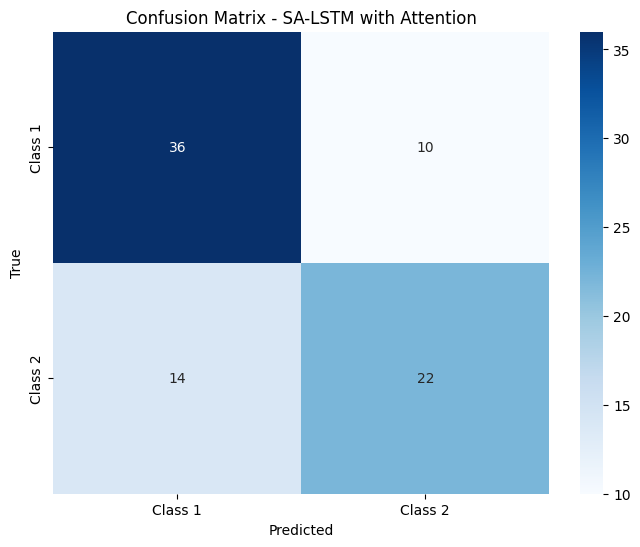

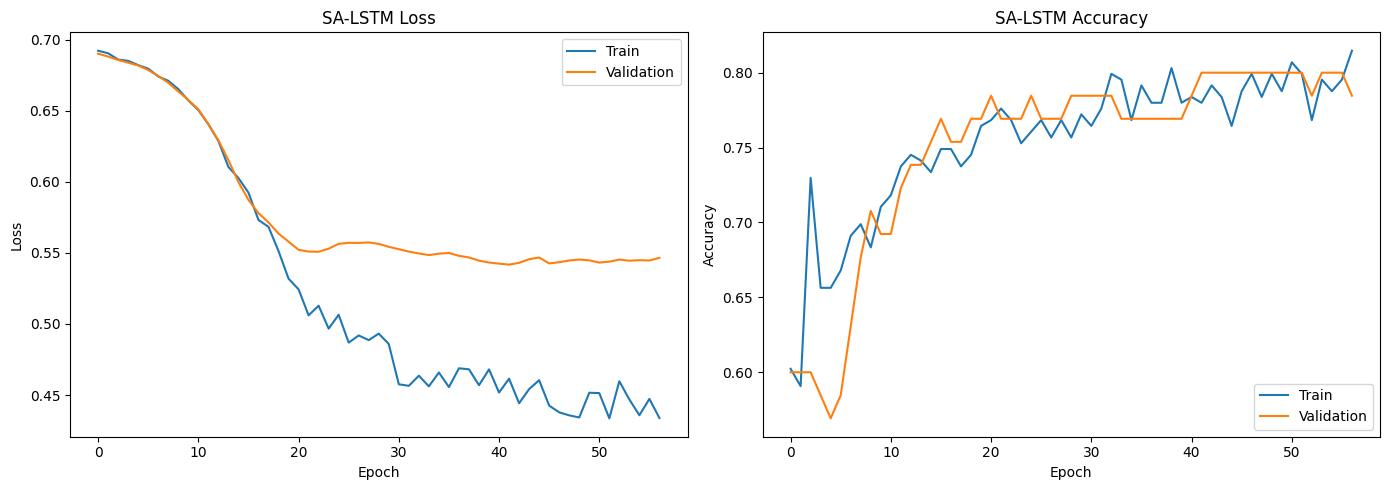

In [166]:

# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [111]:
print(y_test_lstm)
print(y_pred)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]
[0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1
 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0]


# SSA-LSTM

In [158]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(24, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [162]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x1_train, y1_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x1_test, y1_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
# print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_50            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_2        │ (None, 1, 24)          │            25 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 1, 24)          │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_51            │ (None, 1, 24)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_43              │ (None, 24)             │            25 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,579 (37.42 KB)

 Trainable params: 9,531 (37.23 KB)

 Non-trainable params: 48 (192.00 B)

Class weights: {np.int64(0): np.float64(0.8852459016393442), np.int64(1): np.float64(1.148936170212766)}
Epoch 1/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5625 - auc_20: 0.5693 - loss: 0.6747 - precision_20: 0.4118 - recall_20: 0.6364

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5636 - auc_20: 0.5606 - loss: 0.6869 - precision_20: 0.4743 - recall_20: 0.5488 - val_accuracy: 0.7231 - val_auc_20: 0.7554 - val_loss: 0.6849 - val_precision_20: 0.7000 - val_recall_20: 0.5385 - learning_rate: 0.0010
Epoch 2/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6875 - auc_20: 0.6781 - loss: 0.6826 - precision_20: 0.6667 - recall_20: 0.4615

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6584 - auc_20: 0.6747 - loss: 0.6896 - precision_20: 0.6675 - recall_20: 0.4696 - val_accuracy: 0.7538 - val_auc_20: 0.7855 - val_loss: 0.6816 - val_precision_20: 0.7778 - val_recall_20: 0.5385 - learning_rate: 0.0010
Epoch 3/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5625 - auc_20: 0.6032 - loss: 0.6824 - precision_20: 0.4545 - recall_20: 0.3846

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6577 - auc_20: 0.6993 - loss: 0.6806 - precision_20: 0.6183 - recall_20: 0.4753 - val_accuracy: 0.7692 - val_auc_20: 0.7949 - val_loss: 0.6778 - val_precision_20: 0.7895 - val_recall_20: 0.5769 - learning_rate: 0.0010
Epoch 4/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_20: 0.7470 - loss: 0.6772 - precision_20: 0.7000 - recall_20: 0.5385

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7038 - auc_20: 0.7285 - loss: 0.6811 - precision_20: 0.7224 - recall_20: 0.5207 - val_accuracy: 0.7692 - val_auc_20: 0.8033 - val_loss: 0.6739 - val_precision_20: 0.7895 - val_recall_20: 0.5769 - learning_rate: 0.0010
Epoch 5/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_20: 0.7877 - loss: 0.6774 - precision_20: 0.6667 - recall_20: 0.4286

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7075 - auc_20: 0.7708 - loss: 0.6797 - precision_20: 0.7691 - recall_20: 0.5061 - val_accuracy: 0.7538 - val_auc_20: 0.8102 - val_loss: 0.6697 - val_precision_20: 0.7500 - val_recall_20: 0.5769 - learning_rate: 0.0010
Epoch 6/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - auc_20: 0.8300 - loss: 0.6637 - precision_20: 0.7778 - recall_20: 0.5385

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7120 - auc_20: 0.7740 - loss: 0.6743 - precision_20: 0.7429 - recall_20: 0.5290 - val_accuracy: 0.7846 - val_auc_20: 0.8062 - val_loss: 0.6642 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 7/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - auc_20: 0.7540 - loss: 0.6693 - precision_20: 0.5714 - recall_20: 0.5714

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6979 - auc_20: 0.7801 - loss: 0.6724 - precision_20: 0.7113 - recall_20: 0.5844 - val_accuracy: 0.7692 - val_auc_20: 0.8077 - val_loss: 0.6573 - val_precision_20: 0.7391 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 8/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6875 - auc_20: 0.6017 - loss: 0.6586 - precision_20: 0.5556 - recall_20: 0.4545

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7275 - auc_20: 0.7596 - loss: 0.6566 - precision_20: 0.7109 - recall_20: 0.5681 - val_accuracy: 0.7846 - val_auc_20: 0.8141 - val_loss: 0.6478 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 9/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - auc_20: 0.7480 - loss: 0.6676 - precision_20: 0.6667 - recall_20: 0.5000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7134 - auc_20: 0.7976 - loss: 0.6538 - precision_20: 0.7424 - recall_20: 0.5697 - val_accuracy: 0.7846 - val_auc_20: 0.8077 - val_loss: 0.6382 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 10/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - auc_20: 0.8036 - loss: 0.6406 - precision_20: 0.7500 - recall_20: 0.6429

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7455 - auc_20: 0.7922 - loss: 0.6377 - precision_20: 0.7241 - recall_20: 0.6099 - val_accuracy: 0.7846 - val_auc_20: 0.8111 - val_loss: 0.6267 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 11/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_20: 0.7262 - loss: 0.6552 - precision_20: 0.6667 - recall_20: 0.5714

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7043 - auc_20: 0.7792 - loss: 0.6365 - precision_20: 0.7166 - recall_20: 0.5741 - val_accuracy: 0.7846 - val_auc_20: 0.8141 - val_loss: 0.6158 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 12/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - auc_20: 0.7551 - loss: 0.6226 - precision_20: 0.7273 - recall_20: 0.6154

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7615 - auc_20: 0.8159 - loss: 0.6094 - precision_20: 0.7663 - recall_20: 0.6302 - val_accuracy: 0.7846 - val_auc_20: 0.8156 - val_loss: 0.6036 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 13/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7812 - auc_20: 0.8300 - loss: 0.6061 - precision_20: 0.7500 - recall_20: 0.6923

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7190 - auc_20: 0.7999 - loss: 0.6097 - precision_20: 0.7217 - recall_20: 0.5940 - val_accuracy: 0.7692 - val_auc_20: 0.8116 - val_loss: 0.5932 - val_precision_20: 0.7391 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 14/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8438 - auc_20: 0.9250 - loss: 0.5569 - precision_20: 0.7692 - recall_20: 0.8333

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7635 - auc_20: 0.8546 - loss: 0.5771 - precision_20: 0.7550 - recall_20: 0.6612 - val_accuracy: 0.7692 - val_auc_20: 0.8166 - val_loss: 0.5808 - val_precision_20: 0.7391 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 15/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - auc_20: 0.6882 - loss: 0.6609 - precision_20: 0.6429 - recall_20: 0.6000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7379 - auc_20: 0.7948 - loss: 0.5902 - precision_20: 0.7294 - recall_20: 0.6463 - val_accuracy: 0.7846 - val_auc_20: 0.8185 - val_loss: 0.5724 - val_precision_20: 0.7500 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 16/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7812 - auc_20: 0.8806 - loss: 0.5597 - precision_20: 0.7500 - recall_20: 0.6923

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7314 - auc_20: 0.8226 - loss: 0.5722 - precision_20: 0.6941 - recall_20: 0.6801 - val_accuracy: 0.7846 - val_auc_20: 0.8166 - val_loss: 0.5678 - val_precision_20: 0.7500 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 17/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6562 - auc_20: 0.7090 - loss: 0.6211 - precision_20: 0.6667 - recall_20: 0.6250

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7109 - auc_20: 0.7864 - loss: 0.5765 - precision_20: 0.6836 - recall_20: 0.6644 - val_accuracy: 0.7846 - val_auc_20: 0.8200 - val_loss: 0.5621 - val_precision_20: 0.7500 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 18/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - auc_20: 0.8594 - loss: 0.5353 - precision_20: 0.7500 - recall_20: 0.7500

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7760 - auc_20: 0.8545 - loss: 0.5363 - precision_20: 0.7574 - recall_20: 0.7580 - val_accuracy: 0.7846 - val_auc_20: 0.8215 - val_loss: 0.5552 - val_precision_20: 0.7500 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 19/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - auc_20: 0.8314 - loss: 0.5811 - precision_20: 0.8000 - recall_20: 0.7059

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7608 - auc_20: 0.8405 - loss: 0.5316 - precision_20: 0.7657 - recall_20: 0.6923 - val_accuracy: 0.7846 - val_auc_20: 0.8225 - val_loss: 0.5477 - val_precision_20: 0.7500 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 20/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_20: 0.7835 - loss: 0.5932 - precision_20: 0.5833 - recall_20: 0.6364

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7451 - auc_20: 0.8325 - loss: 0.5309 - precision_20: 0.7233 - recall_20: 0.6693 - val_accuracy: 0.8000 - val_auc_20: 0.8245 - val_loss: 0.5389 - val_precision_20: 0.7826 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 21/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - auc_20: 0.8863 - loss: 0.4775 - precision_20: 0.8000 - recall_20: 0.7059

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7778 - auc_20: 0.8649 - loss: 0.4886 - precision_20: 0.7853 - recall_20: 0.6930 - val_accuracy: 0.7846 - val_auc_20: 0.8259 - val_loss: 0.5318 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 22/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_20: 0.7611 - loss: 0.5617 - precision_20: 0.6667 - recall_20: 0.6154

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7395 - auc_20: 0.8364 - loss: 0.5069 - precision_20: 0.7141 - recall_20: 0.6591 - val_accuracy: 0.7846 - val_auc_20: 0.8274 - val_loss: 0.5318 - val_precision_20: 0.7727 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 23/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - auc_20: 0.8704 - loss: 0.4769 - precision_20: 0.7692 - recall_20: 0.7692

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7338 - auc_20: 0.8270 - loss: 0.5220 - precision_20: 0.7275 - recall_20: 0.6410 - val_accuracy: 0.8154 - val_auc_20: 0.8294 - val_loss: 0.5292 - val_precision_20: 0.8182 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 24/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7188 - auc_20: 0.8175 - loss: 0.5215 - precision_20: 0.7273 - recall_20: 0.5714

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7585 - auc_20: 0.8568 - loss: 0.4882 - precision_20: 0.7884 - recall_20: 0.6285 - val_accuracy: 0.8154 - val_auc_20: 0.8279 - val_loss: 0.5262 - val_precision_20: 0.8182 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 25/150
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - auc_20: 0.9471 - loss: 0.3843 - precision_20: 0.9231 - recall_20: 0.8000

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7991 - auc_20: 0.8668 - loss: 0.4745 - precision_20: 0.8046 - recall_20: 0.7101 - val_accuracy: 0.8154 - val_auc_20: 0.8289 - val_loss: 0.5260 - val_precision_20: 0.8182 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 26/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7163 - auc_20: 0.8068 - loss: 0.5318 - precision_20: 0.7337 - recall_20: 0.6471 - val_accuracy: 0.8154 - val_auc_20: 0.8323 - val_loss: 0.5285 - val_precision_20: 0.8182 - val_recall_20: 0.6923 - learning_rate: 0.0010
Epoch 27/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7638 - auc_20: 0.8729 - loss: 0.4711 - precision_20: 0.7492 - recall_20: 0.6782 - val_accuracy: 0.8000 - val_auc_20: 0.8304 - val_loss: 0.5266 - val_precision_20: 0.8095 - val_recall_20: 0.6538 - learning_rate: 0.0010
Epoch 28/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7597 - auc_20: 0.8327 - loss: 0.4944 - precision_20: 0.7648 - recall_20: 0.6667 - val_accuracy: 0.8

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7509 - auc_20: 0.7984 - loss: 0.5451 - precision_20: 0.7479 - recall_20: 0.6562
Test loss: 0.5486
Test accuracy: 0.7439
Test AUC: 0.7732
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

LSTM with Attention Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        46
           1       0.76      0.61      0.68        36

    accuracy                           0.74        82
   macro avg       0.75      0.73      0.73        82
weighted avg       0.75      0.74      0.74        82



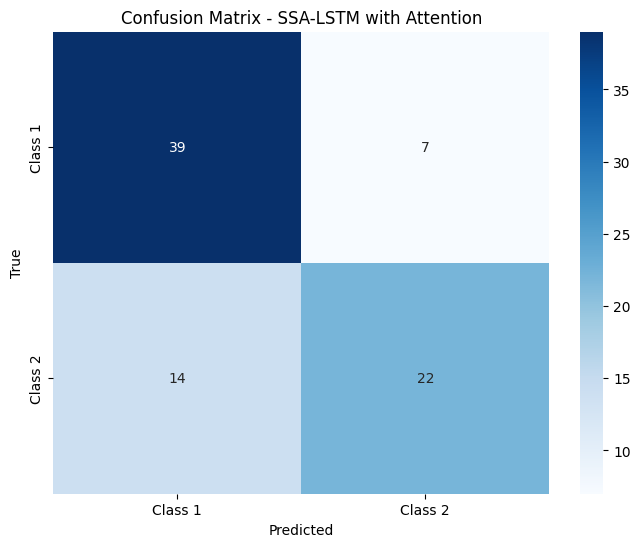

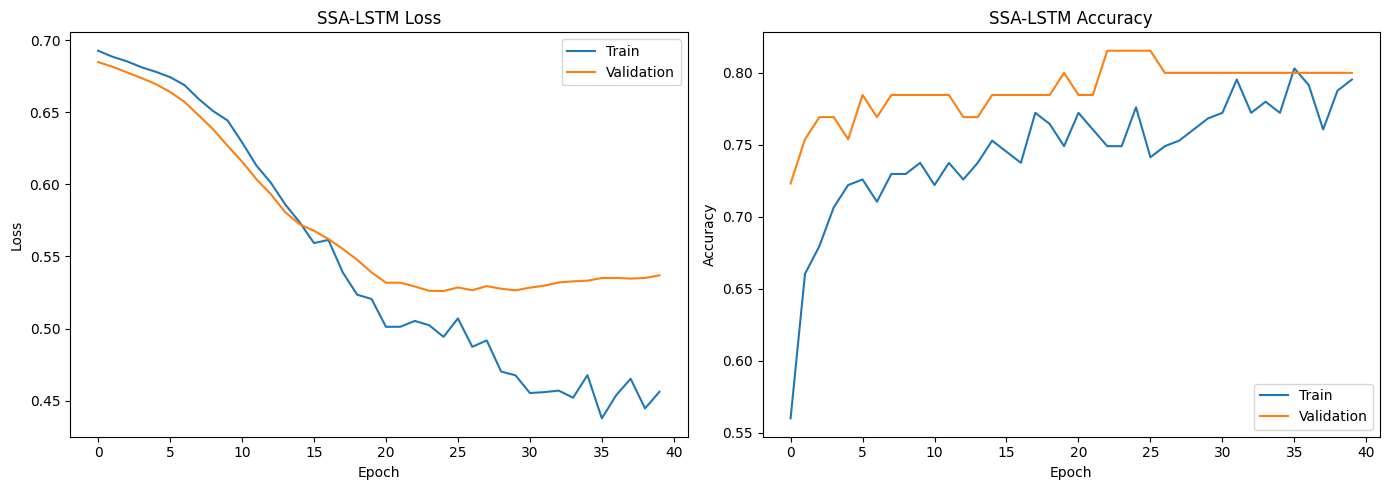

In [164]:
# Evaluate on test set
test_results = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
# Make predictions
y_pred_proba = model.predict(X_test_lstm, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Flatten to ensure compatible shape
# Make predictions
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM with Attention Classification Report:")
print(classification_report(y_test_lstm, y_pred))



# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_lstm, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 1', 'Class 2'],
            yticklabels=['Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SSA-LSTM with Attention')
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SSA-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SSA-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [161]:
print(y_test_lstm)
print(y_pred)

[0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 1]
[0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1
 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Average middle_attention_layer_3 Feature Attention: [[ 0.24633366  0.12806635  0.02766966  0.07298683 -0.12018932 -0.00789264
   0.16374677  0.14504084 -0.01217121 -0.12081349 -0.07191792 -0.15303034
  -0.03299381 -0.16096064 -0.1083713   0.16433103  0.20612131  0.06408544
  -0.07871827  0.17225389  0.15254466 -0.02730335 -0.24182177 -0.01120282]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Average Feature Attention: [[ 0.09508305 -0.07880491  0.15386024  0.06694753 -0.12277978  0.13971575
   0.07813511 -0.16364881 -0.12817812  0.12928922 -0.13071807 -0.14127463
   0.15449628  0.177374    0.11385121  0.14664383  0.11387639 -0.0928159
   0.12602553 -0.13829754  0.08547271  0.12286895  0.13843434 -0.12860641]]


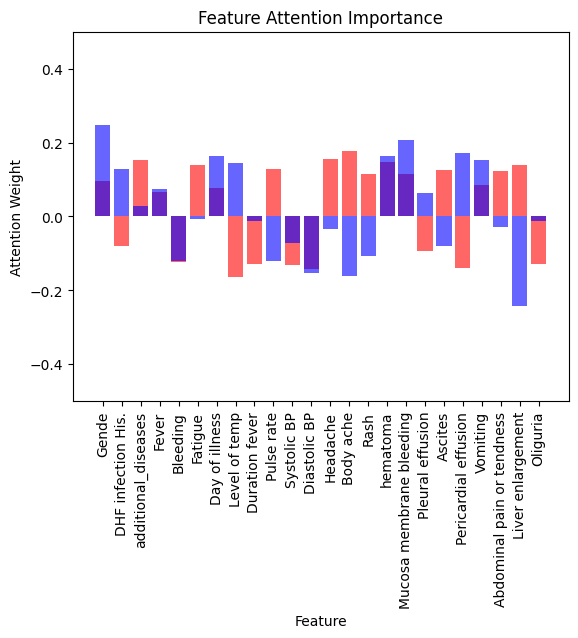

In [221]:
# Example input: (1 sample, 1 time steps, 24 features)
example_input = np.random.rand(1, 1, 24).astype(np.float32)

middle_attention_layer_3 = Model(inputs=model.input,
                        outputs=model.get_layer('middle_attention_layer_3').output)


middle_attention_layer_3_output = middle_attention_layer_3.predict(example_input)

middle_attention_layer_3_feature_attention = middle_attention_layer_3_output.mean(axis=1)  # (1, 24)
print("Average middle_attention_layer_3 Feature Attention:", middle_attention_layer_3_feature_attention)

# sorted_indices_middle_layer = np.argsort(middle_attention_layer_3_feature_attention)[::-1]  # Sort indices in descending order
# sorted_names_middle_layer = x1_features.to_numpy()[sorted_indices_middle_layer]
# sorted_scores_middle_layer = middle_attention_layer_3_feature_attention[0][sorted_indices_middle_layer]
# print('asda',sorted_names_middle_layer)

# ATTENTION LAYER 44
attention_layer_44 = Model(inputs=model.input,
                        outputs=model.get_layer('attention_layer_44').output)


attention_layer_44_output = attention_layer_44.predict(example_input)
# sorted_indices_last_layer = np.argsort(attention_layer_44_output)[::-1]  # Sort indices in descending order
# sorted_names_last_layer = x1_features.to_numpy()[sorted_indices_last_layer]
# sorted_scores_last_layer = attention_layer_44_output[0][sorted_indices_last_layer]

print("Average Feature Attention:", attention_layer_44_output)


plt.bar(range(24), attention_layer_44_output[0], color='red', alpha=0.6)
plt.bar(range(24), middle_attention_layer_3_feature_attention[0], color='blue', alpha=0.6)
plt.xticks(range(24), [x1_features[i] for i in range(24)], rotation=90)
plt.title("Feature Attention Importance")
plt.ylabel("Attention Weight")
plt.xlabel("Feature")
plt.ylim(-0.5, 0.5)

plt.show()